# Framingham Heart Study
## Analysis and Machine Learning model

In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [8]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Importing the data

In [3]:
framingham_df = pd.read_csv("../resources/framingham.csv")
framingham_df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


## Data Inspection

In [4]:
# Quick glance at what single variable has the highest correlation with a stroke
framingham_df.corr()['TenYearCHD']\
    .sort_values(ascending=False)

TenYearCHD         1.000000
age                0.225256
sysBP              0.216429
prevalentHyp       0.177603
diaBP              0.145299
glucose            0.125544
diabetes           0.097317
male               0.088428
BPMeds             0.087489
totChol            0.082184
BMI                0.075192
prevalentStroke    0.061810
cigsPerDay         0.057884
heartRate          0.022913
currentSmoker      0.019456
education         -0.054059
Name: TenYearCHD, dtype: float64

<AxesSubplot:>

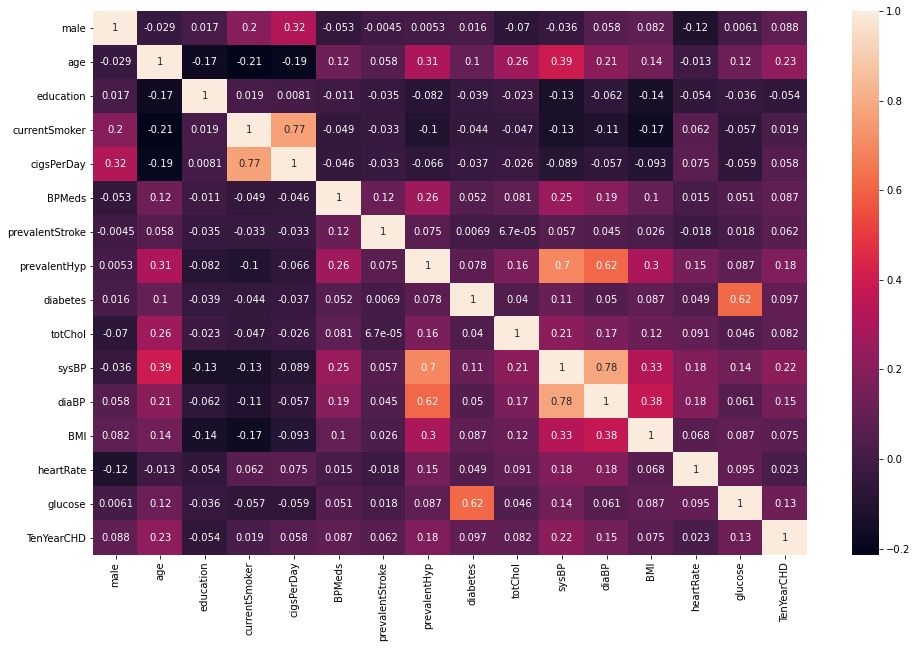

In [5]:
# Visualize the correlations.
import seaborn as sb
import matplotlib.pyplot as plt
plt.figure(figsize=(16,10))
sb.heatmap(framingham_df.corr(), annot=True)

### Quick analysis 

A quick glance shows that age seems to be the most correlated with having a stroke.

## Build the model

In [33]:
# Generate categorical variable list
fram_cat = framingham_df.dtypes[framingham_df.dtypes == "object"].index.tolist()

In [35]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(framingham_df[fram_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(fram_cat)
encode_df.head()

""
0
1
2
3
4


In [36]:
# Merge one-hot encoded features and drop the originals
framingham_df = framingham_df.merge(encode_df, left_index=True, right_index=True)
framingham_df = framingham_df.drop(fram_cat, 1)
framingham_df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [37]:
# Split our preprocessed data into our features and target arrays
y = framingham_df.TenYearCHD
X = framingham_df.drop(columns=['TenYearCHD'])

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)

In [39]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [40]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [44]:
# Create a checkpoint of the model
checkpoint_filepath = '../resources/model/checkpoints/framingham.h5'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='accuracy', 
    mode='max',
    save_best_only=True,
    save_freq=5,
    verbrose=1
)

In [45]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X.columns)

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    Dense(
        units=number_input_features * 2,
        input_dim=number_input_features,
        activation='relu'
    )
)

# Second hidden layer
nn.add(
    Dense(
        units=number_input_features,
        activation='relu'
    )
)

# Output layer
nn.add(
    Dense(
        units=1,
        activation='sigmoid'
    )
)

# Check the structure of the model
nn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_4 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 16        
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________


In [46]:
# Compile the model
nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["accuracy"])

# Fit the model
nn.fit(
    X_train_scaled, 
    np.asarray(y_train), 
    epochs=100,
    callbacks=checkpoint_callback
)

Epoch 1/100
100/100 [==============================] - 1s 999us/step - loss: nan - accuracy: 0.8502
Epoch 2/100
100/100 [==============================] - 0s 827us/step - loss: nan - accuracy: 0.8512
Epoch 3/100
100/100 [==============================] - 0s 858us/step - loss: nan - accuracy: 0.8512
Epoch 4/100
100/100 [==============================] - 0s 868us/step - loss: nan - accuracy: 0.8512
Epoch 5/100
100/100 [==============================] - 0s 989us/step - loss: nan - accuracy: 0.8512
Epoch 6/100
100/100 [==============================] - 0s 858us/step - loss: nan - accuracy: 0.8512
Epoch 7/100
100/100 [==============================] - 0s 848us/step - loss: nan - accuracy: 0.8512
Epoch 8/100
100/100 [==============================] - 0s 959us/step - loss: nan - accuracy: 0.8512
Epoch 9/100
100/100 [==============================] - 0s 797us/step - loss: nan - accuracy: 0.8512
Epoch 10/100
100/100 [==============================] - 0s 807us/step - loss: nan - accuracy: 0.8512

100/100 [==============================] - 0s 847us/step - loss: nan - accuracy: 0.8512
Epoch 83/100
100/100 [==============================] - 0s 797us/step - loss: nan - accuracy: 0.8512
Epoch 84/100
100/100 [==============================] - 0s 787us/step - loss: nan - accuracy: 0.8512
Epoch 85/100
100/100 [==============================] - 0s 797us/step - loss: nan - accuracy: 0.8512
Epoch 86/100
100/100 [==============================] - 0s 787us/step - loss: nan - accuracy: 0.8512
Epoch 87/100
100/100 [==============================] - 0s 777us/step - loss: nan - accuracy: 0.8512
Epoch 88/100
100/100 [==============================] - 0s 787us/step - loss: nan - accuracy: 0.8512
Epoch 89/100
100/100 [==============================] - 0s 797us/step - loss: nan - accuracy: 0.8512
Epoch 90/100
100/100 [==============================] - 0s 858us/step - loss: nan - accuracy: 0.8512
Epoch 91/100
100/100 [==============================] - 0s 838us/step - loss: nan - accuracy: 0.8512
Epo

In [47]:
# The model weights (that are considered the best) are loaded into the model.
nn.load_weights(checkpoint_filepath)

# Check accuracy
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

34/34 - 0s - loss: nan - accuracy: 0.8387
Loss: nan, Accuracy: 0.8386792540550232


In [48]:
# Save the model
nn.save('../resources/model/framingham.h5')

## Summary